In [1]:
%matplotlib widget

In [2]:
%cd ..

d:\Users\NitroPC\Documents\Python\ConcursoModelizacion2023


In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from gradient_descent import Environment, Agent, ConstrainedLoss, CostLoss, DistanceLoss, optimize
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.collections import LineCollection
from utils import plot_location
import matplotlib as mpl

In [4]:
dt = 1.
g = 0.1
m = 10.
F_max = 11.
p_0 = np.array([50., 50., 100.])
v_0 = np.array([-10., 0., -10.])
alpha = 0.5
gamma = 1.

In [5]:
def check_factibility(K):
    agent = Agent(K)
    env = Environment(dt, gamma, g, m, p_0, v_0)

    loss = ConstrainedLoss(dt, gamma, F_max, alpha)
    optim = torch.optim.RMSprop(agent.parameters(), lr=1e-0)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.995)

    optimize(env, agent, loss, optim, scheduler, iters=2000, verbose=True)

    d_loss = DistanceLoss()
    c_loss = CostLoss(dt, gamma)
    f = agent()
    p, v = env(f)
    d1, d2 = d_loss(f, p, v)
    d1, d2 = d1.item(), d2.item()

    factible = False
    if d1<.5 and d2<.5:
        factible = True

    loss_c = c_loss(f, p, v)

    result = [K, d1, d2, loss_c.item(), factible]
    print(result)

    return result

In [6]:
results = []
for i in range(19, 40):
    results += [check_factibility(i)]

35400.55859375 [0.995]
492.8645324707031 [0.6027415843082742]
302.2021484375 [0.36512303261753626]
331.8484191894531 [0.2211807388415433]
266.9276428222656 [0.13398475271138335]
250.36749267578125 [0.0811640021330769]
224.99423217773438 [0.04916675299948831]
226.27215576171875 [0.029783765425331846]
225.83480834960938 [0.018042124582040707]
220.52027893066406 [0.010929385683282892]
220.08358764648438 [0.0066206987359377885]
221.51788330078125 [0.004010623563142642]
220.08062744140625 [0.0024295171864449163]
219.70211791992188 [0.001471729686494462]
219.79258728027344 [0.0008915303345841139]
219.46690368652344 [0.0005400627199257432]
219.34584045410156 [0.00032715402958178723]
219.28353881835938 [0.00019818023929945992]
219.2931671142578 [0.0001200517300642707]
219.26622009277344 [7.27237889225003e-05]
[19, 0.0010428389068692923, 0.7295007705688477, 204.66993713378906, False]
41447.37890625 [0.995]
402.9755554199219 [0.6027415843082742]
298.9983825683594 [0.36512303261753626]
238.966156

In [7]:
np_results = np.array(results)

In [8]:
with open('test.npy', 'wb') as f:
    np.save(f, np_results)
with open('test.npy', 'rb') as f:
    np_results = np.load(f)

In [9]:
np_results.shape

(21, 5)

In [10]:
np.argmin(np_results[:,3])

13

In [11]:
np_results[15,3]

187.90606689453125

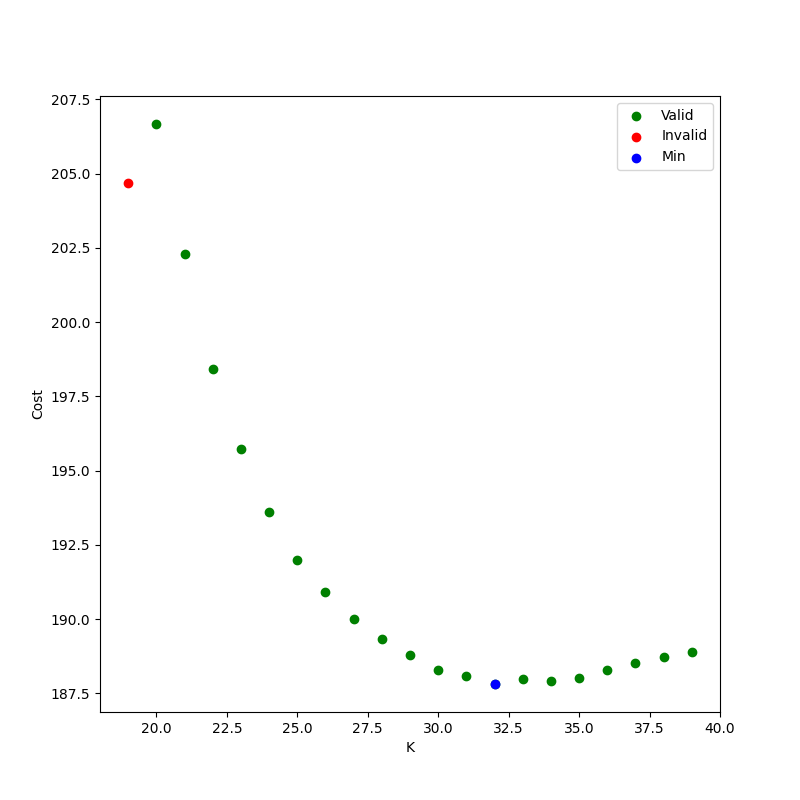

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(np.arange(20,40,1), np_results[1:,3], label='Valid', c='g')
ax.scatter([19],np_results[0,3], label='Invalid', c='r')
ax.scatter([32], np_results[13,3], label='Min', c='b')
#ax.plot(np.arange(0,2000,10), losses_2, label='Cost')
#ax.set_title('Loss')
#ax.set_yscale('log')

ax.set_ylabel('Cost')
ax.set_xlabel('K')
ax.legend()
plt.savefig("images/K_multi_cost_v5.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [13]:
def optimize(env, agent, loss, loss2, optim, scheduler=None, iters=10000, verbose=True):
    losses_1, losses_2 = [], []
    params = []
    
    for i in range(iters):
        f = agent()
        p, v = env(f)
        l = loss(f, p, v)

        optim.zero_grad()
        l.backward(retain_graph=True)

        torch.nn.utils.clip_grad_norm_(agent.parameters(), 10.)
        optim.step()

        if scheduler is not None:
            scheduler.step()

        if verbose and i%10==0:
            l1 = l.item()
            losses_1 += [l1]
            losses_2 += [loss2(f, p, v).item()]
            params += [f.detach().clone().numpy()]

            print(l1, scheduler.get_last_lr())
            
    return losses_1, losses_2, params

In [14]:
K=20
agent = Agent(K)
env = Environment(dt, gamma, g, m, p_0, v_0)

loss = ConstrainedLoss(dt, gamma, F_max, alpha)
loss2 = CostLoss(dt, gamma)
optim = torch.optim.RMSprop(agent.parameters(), lr=1e-0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.995)


In [15]:
%%time
losses_1, losses_2, params = optimize(env, agent, loss, loss2, optim, scheduler, iters=2000, verbose=True)

41447.37890625 [0.995]
1517.5955810546875 [0.946354579813443]
1165.36181640625 [0.9000874278732445]
451.19903564453125 [0.8560822709551227]
875.536865234375 [0.8142285204175609]
641.6854248046875 [0.7744209942832988]
522.6712036132812 [0.736559652908221]
437.1925964355469 [0.7005493475733617]
400.50787353515625 [0.6662995813682115]
338.71917724609375 [0.6337242817644086]
402.9755554199219 [0.6027415843082742]
389.67498779296875 [0.5732736268885887]
371.0785827636719 [0.5452463540625918]
364.5440979003906 [0.5185893309484582]
338.20855712890625 [0.4932355662165453]
363.45550537109375 [0.46912134373457726]
415.998291015625 [0.446186062443672]
375.6998596191406 [0.42437208406280985]
344.2945556640625 [0.4036245882390106]
314.4852600097656 [0.38389143477919885]
298.9983825683594 [0.36512303261753626]
265.850341796875 [0.3472722151889232]
261.3362731933594 [0.3302941218954743]
429.0356140136719 [0.3141460853680822]
304.74853515625 [0.2987875242397482]
304.4258728027344 [0.28417984116121187]

In [30]:
f = agent()
p, v = env(f)

In [31]:
d_loss = DistanceLoss()
c_loss = CostLoss(dt, gamma)

In [32]:
print(loss(f, p, v))
print(d_loss(f, p, v))
print(c_loss(f, p, v))

tensor(208.7170, grad_fn=<AddBackward0>)
(tensor(0.0001, grad_fn=<LinalgVectorNormBackward0>), tensor(0.1015, grad_fn=<LinalgVectorNormBackward0>))
tensor(206.6826, grad_fn=<MulBackward0>)


In [19]:
f = agent()
p, v = env(f)

d1, d2 = d_loss(f, p, v)
d1, d2 = d1.item(), d2.item()

factible = False
if d1<1. and d2<1.:
    factible = True

print(K, d1, d2, factible)

20 0.0007691359496675432 0.10466130822896957 True


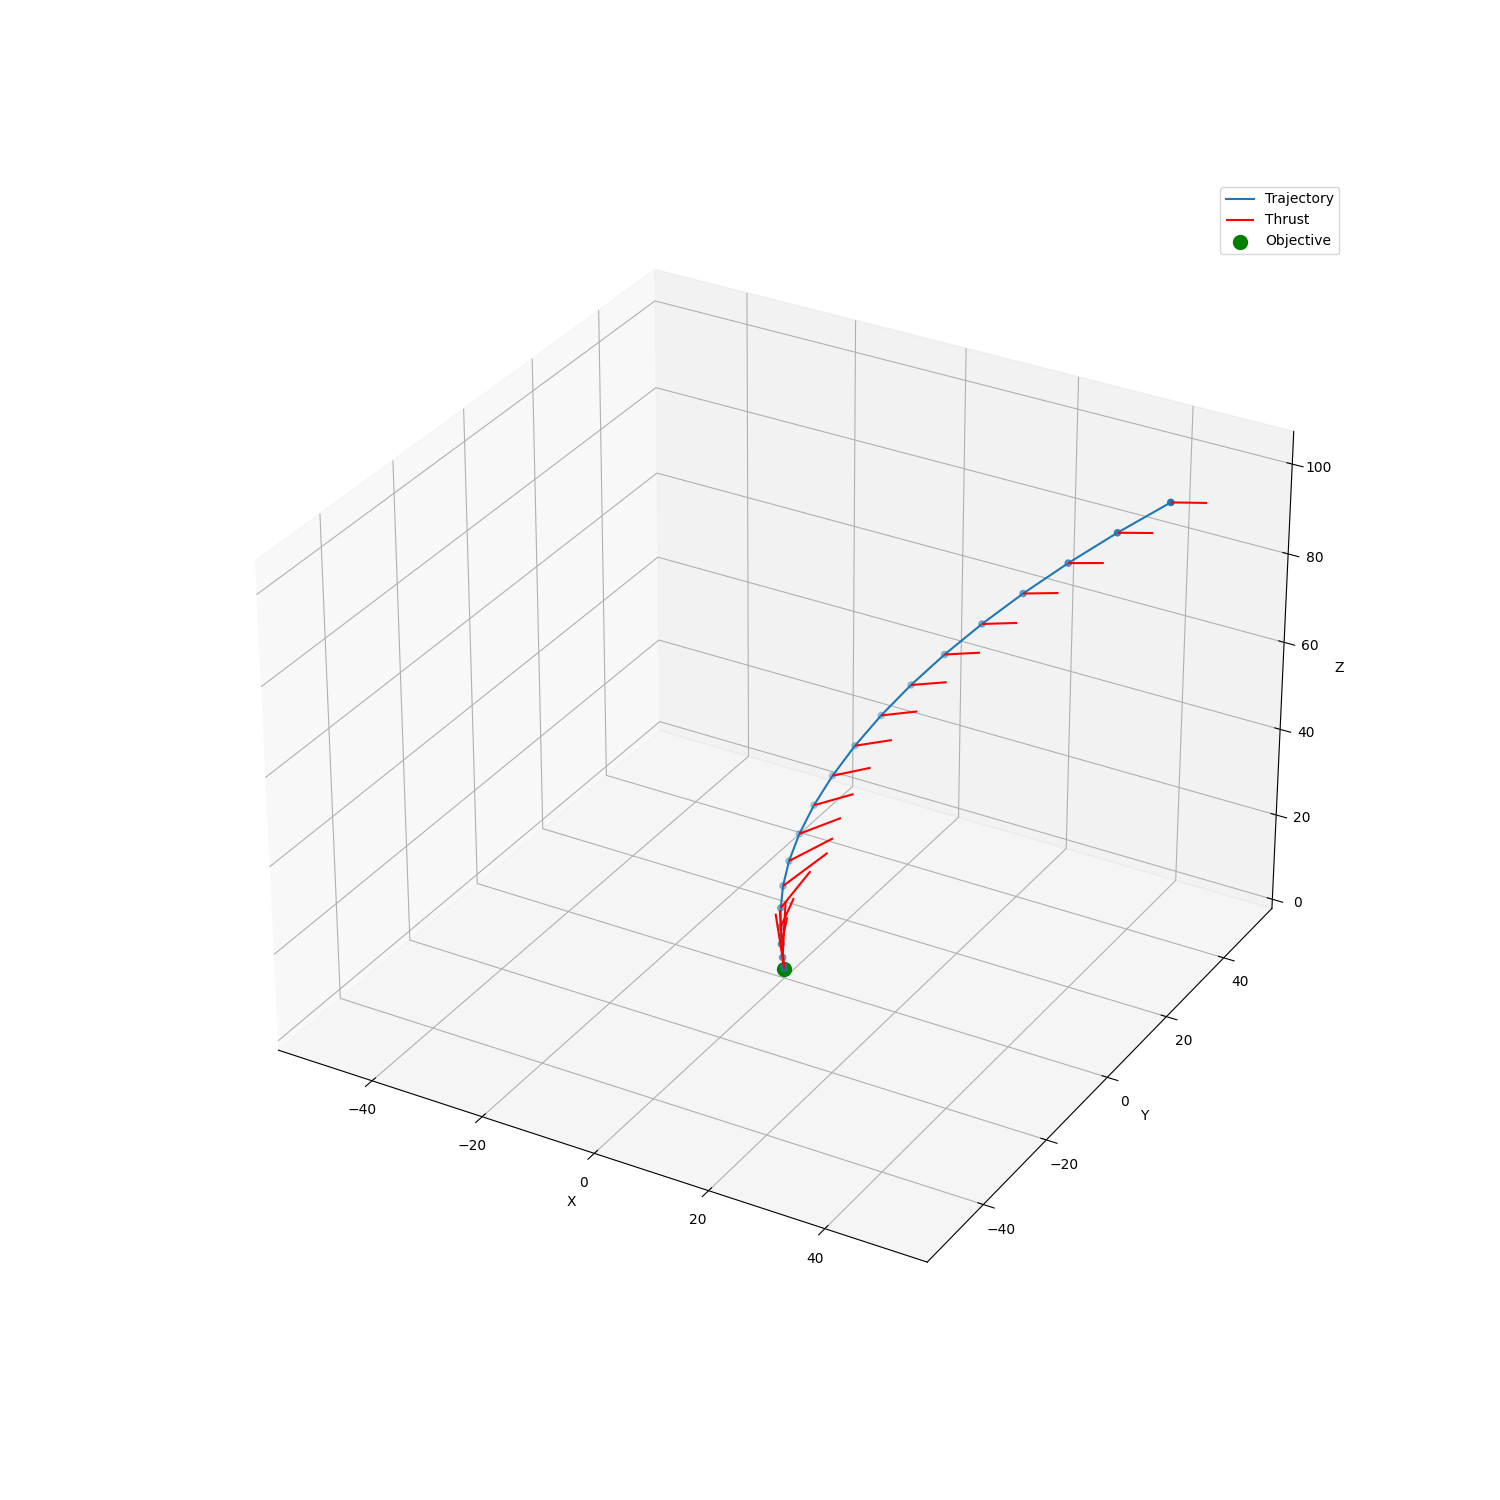

In [20]:
plot_location(f, p, v, lambd=1.0)

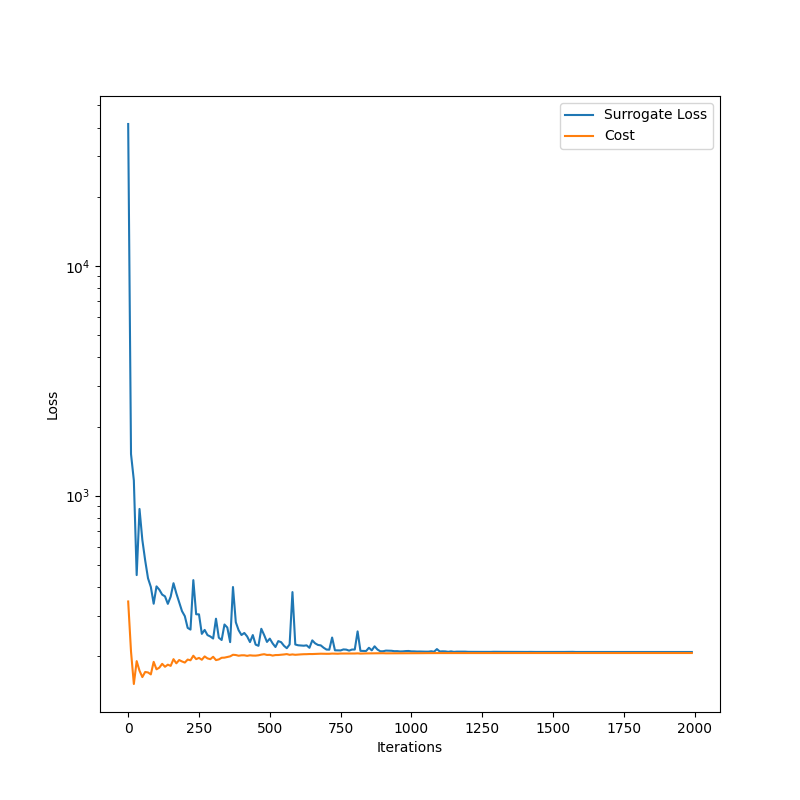

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(np.arange(0,2000,10), losses_1, label='Surrogate Loss')
ax.plot(np.arange(0,2000,10), losses_2, label='Cost')
#ax.set_title('Loss')
ax.set_yscale('log')

ax.set_ylabel('Loss')
ax.set_xlabel('Iterations')
ax.legend()
plt.savefig("images/K_20_loss_v5.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [22]:
params_np = np.array(params)

C:\Users\danie\AppData\Local\Temp\ipykernel_9832\1873518076.py:30: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=np.linspace(0, 2000, 11))


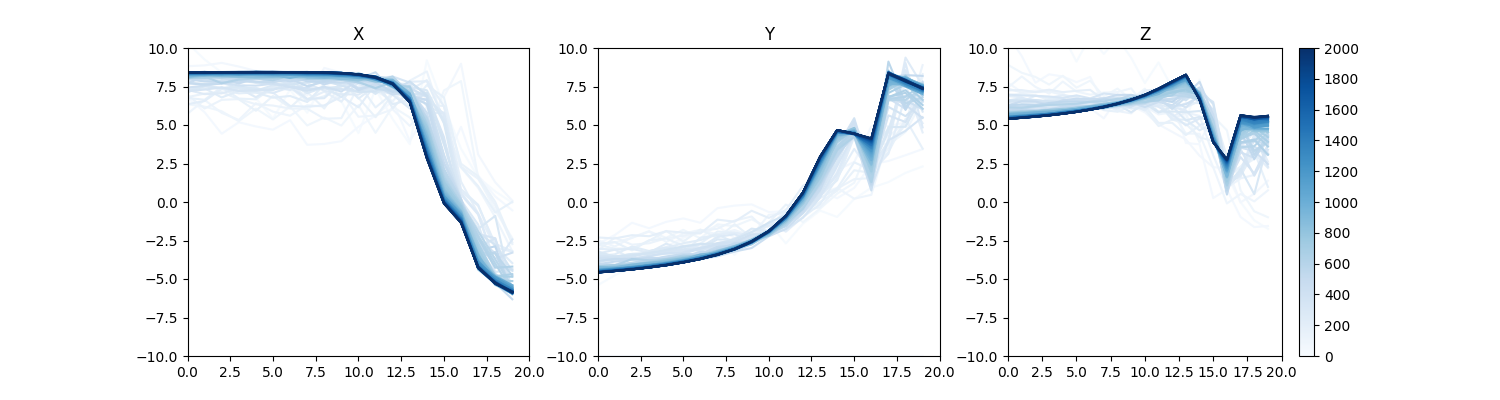

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

num = 100
colors = plt.cm.Blues(np.linspace(0,1,num))

for i in range(num):
    axs[0].plot(params_np[i,:,0], color=colors[i])
    axs[1].plot(params_np[i,:,1], color=colors[i])
    axs[2].plot(params_np[i,:,2], color=colors[i])
axs[0].set_title('X')
axs[1].set_title('Y')
axs[2].set_title('Z')

axs[0].set_ylim(-10, 10)
axs[1].set_ylim(-10, 10)
axs[2].set_ylim(-10, 10)

axs[0].set_xlim(0,K)
axs[1].set_xlim(0,K)
axs[2].set_xlim(0,K)

axs[2].xaxis.set_ticks(np.arange(0,22.5,2.5))

norm = mpl.colors.Normalize(vmin=0, vmax=2000)
  
# creating ScalarMappable
sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=norm)
sm.set_array([])
  
plt.colorbar(sm, ticks=np.linspace(0, 2000, 11))


plt.savefig("images/K_20_fuerza_v4.pdf", format="pdf", bbox_inches="tight")
plt.show()

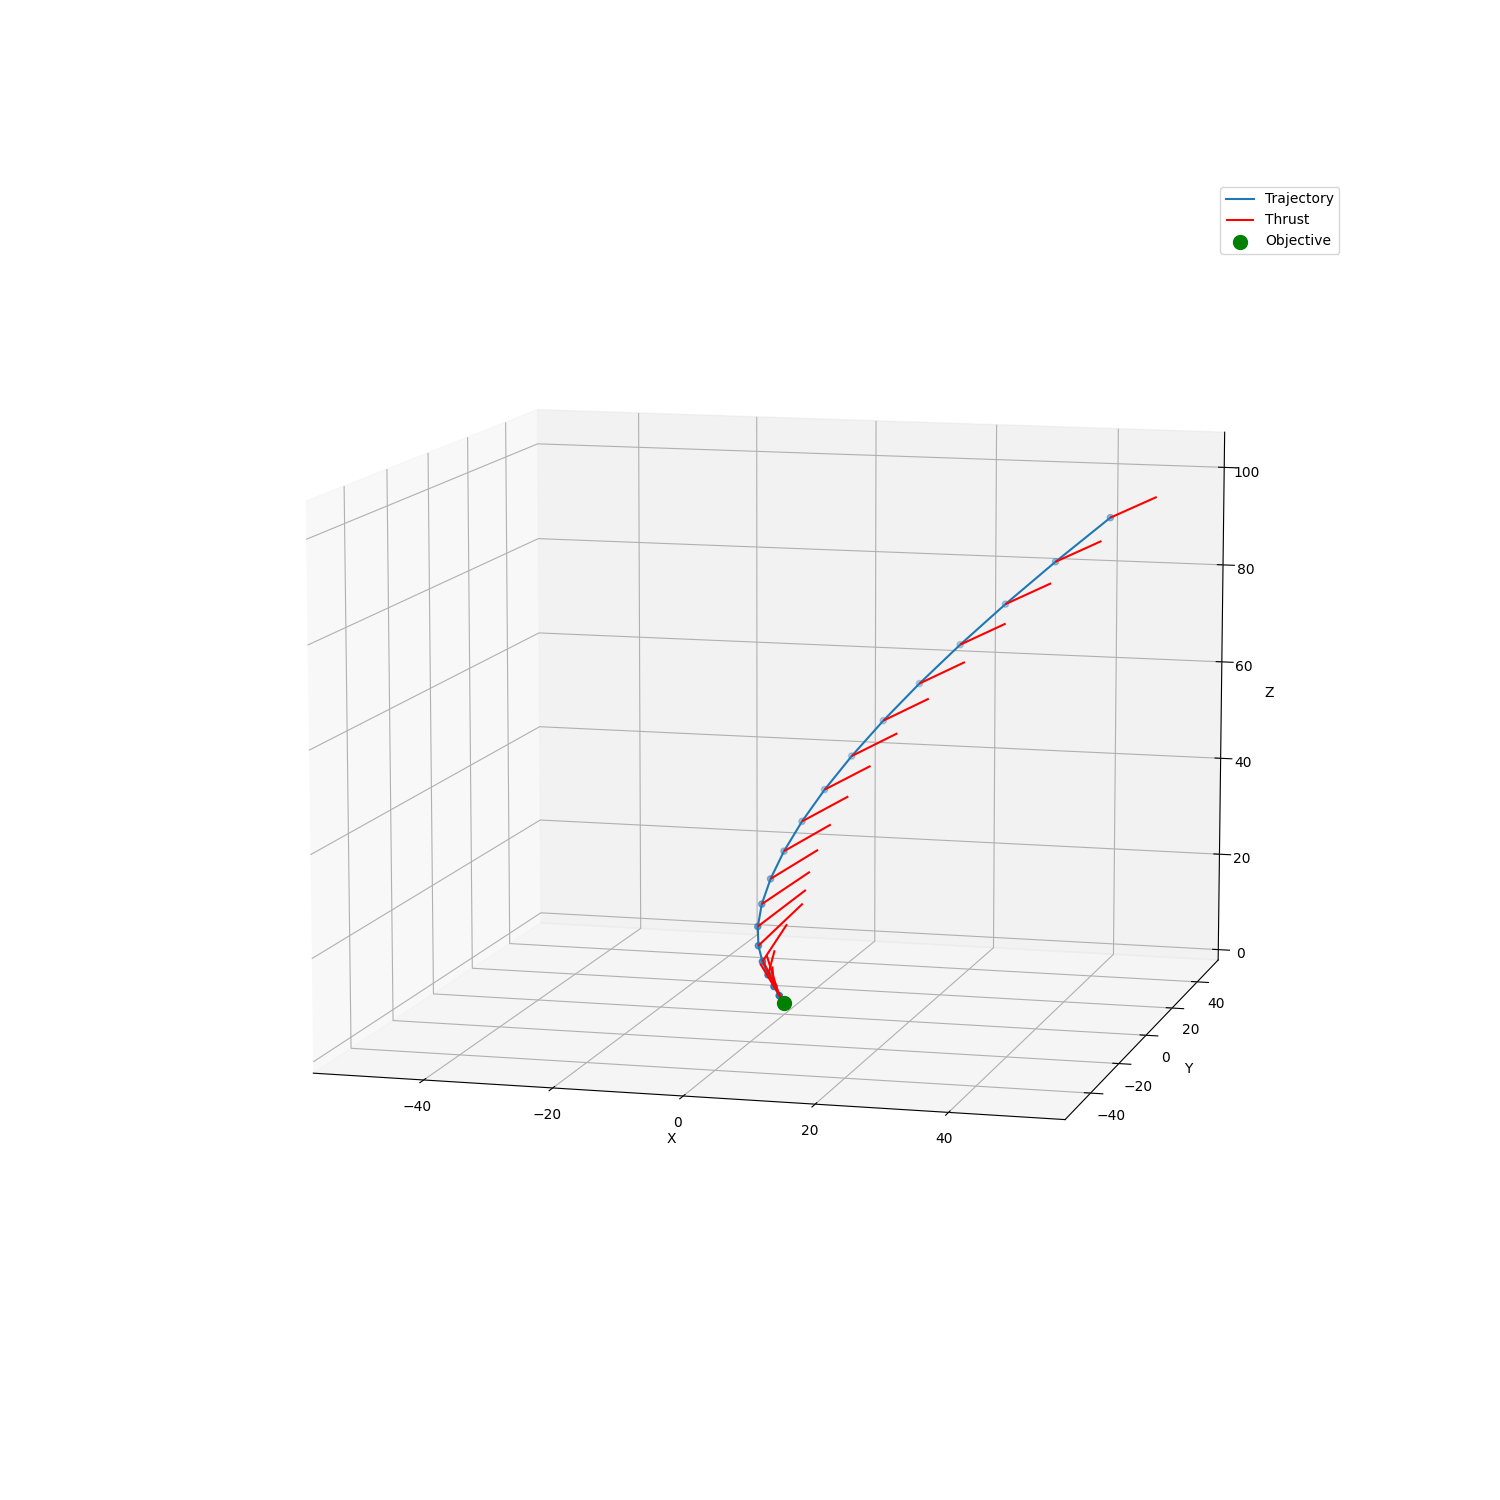

In [24]:
lambd = 1.
if isinstance(p, torch.Tensor) and isinstance(v, torch.Tensor):
    p = p.detach().numpy()
    v = v.detach().numpy()
    f = f.detach().numpy()

ax = plt.figure(figsize=(15,15)).add_subplot(projection='3d')
ax.plot(p[:,0], p[:,1], p[:,2], zdir='z', label='Trajectory')
ax.scatter(p[:,0], p[:,1], p[:,2], zdir='z')

p2 = p + lambd*f
p_combine = np.stack([p, p2]).transpose((1, 0, 2))
lines = Line3DCollection(p_combine, color='r', label='Thrust')
ax.add_collection(lines)


ax.scatter(0,0,0, zdir='z', c='g', s=100, label='Objective')
ax.legend()
ax.set_xlim(-55, 55)
ax.set_ylim(-55, 55)
ax.set_zlim(0, 105)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(azim=-75, elev=10)

plt.savefig("images/K_20_optimal_v3.pdf", format="pdf", bbox_inches="tight")
plt.show()

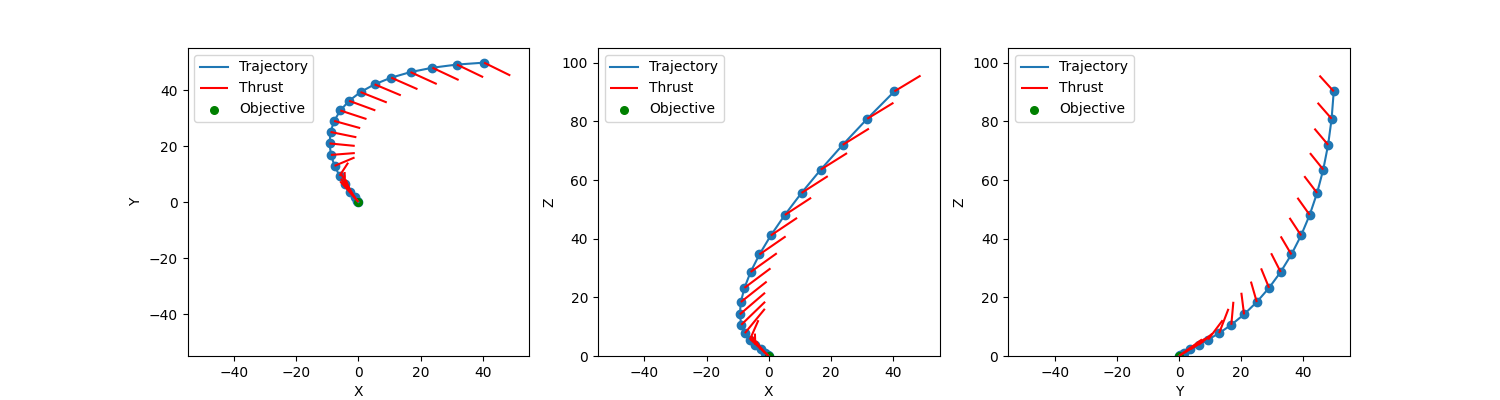

In [25]:
lambd = 1.
if isinstance(p, torch.Tensor) and isinstance(v, torch.Tensor):
    p = p.detach().numpy()
    v = v.detach().numpy()
    f = f.detach().numpy()

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].plot(p[:,0], p[:,1], label='Trajectory')
axs[0].scatter(p[:,0], p[:,1])

p2 = p + lambd*f
p_combine = np.stack([p, p2])[:,:,[0,1]].transpose((1,0,2))
lines = LineCollection(p_combine, color='r', label='Thrust')
axs[0].add_collection(lines)
axs[0].scatter(0,0, c='g', s=30, label='Objective')
axs[0].legend()
axs[0].set_xlim(-55, 55)
axs[0].set_ylim(-55, 55)
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')


axs[1].plot(p[:,0], p[:,2], label='Trajectory')
axs[1].scatter(p[:,0], p[:,2])
p2 = p + lambd*f
p_combine = np.stack([p, p2])[:,:,[0,2]].transpose((1,0,2))
lines = LineCollection(p_combine, color='r', label='Thrust')
axs[1].add_collection(lines)
axs[1].scatter(0,0, c='g', s=30, label='Objective')
axs[1].legend()
axs[1].set_xlim(-55, 55)
axs[1].set_ylim(0, 105)
axs[1].set_xlabel('X')
axs[1].set_ylabel('Z')


axs[2].plot(p[:,1], p[:,2], label='Trajectory')
axs[2].scatter(p[:,1], p[:,2])
p2 = p + lambd*f
p_combine = np.stack([p, p2])[:,:,[1,2]].transpose((1,0,2))
lines = LineCollection(p_combine, color='r', label='Thrust')
axs[2].add_collection(lines)
axs[2].scatter(0,0, c='g', s=30, label='Objective')
axs[2].legend()
axs[2].set_xlim(-55, 55)
axs[2].set_ylim(0, 105)
axs[2].set_xlabel('Y')
axs[2].set_ylabel('Z')

plt.savefig("images/K_20_optimal_X_Y.pdf", format="pdf", bbox_inches="tight")
plt.show()